# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import pandas as pd

training_file = "./traffic-signs-data/train.p"
validation_file="./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Load names of classes of traffic signs from file
with open('signnames.csv', mode = 'rb') as f:
    signs_description_file_content = pd.read_csv(f)
#create a 2d array with format [[class_index, class_name]] from 'signnames' file
signs_description = signs_description_file_content.as_matrix()

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

#check whether amount of pairs class_index<->class_name in a signnames' file is equal to amount of classes in data set 
assert len(signs_description) == n_classes


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

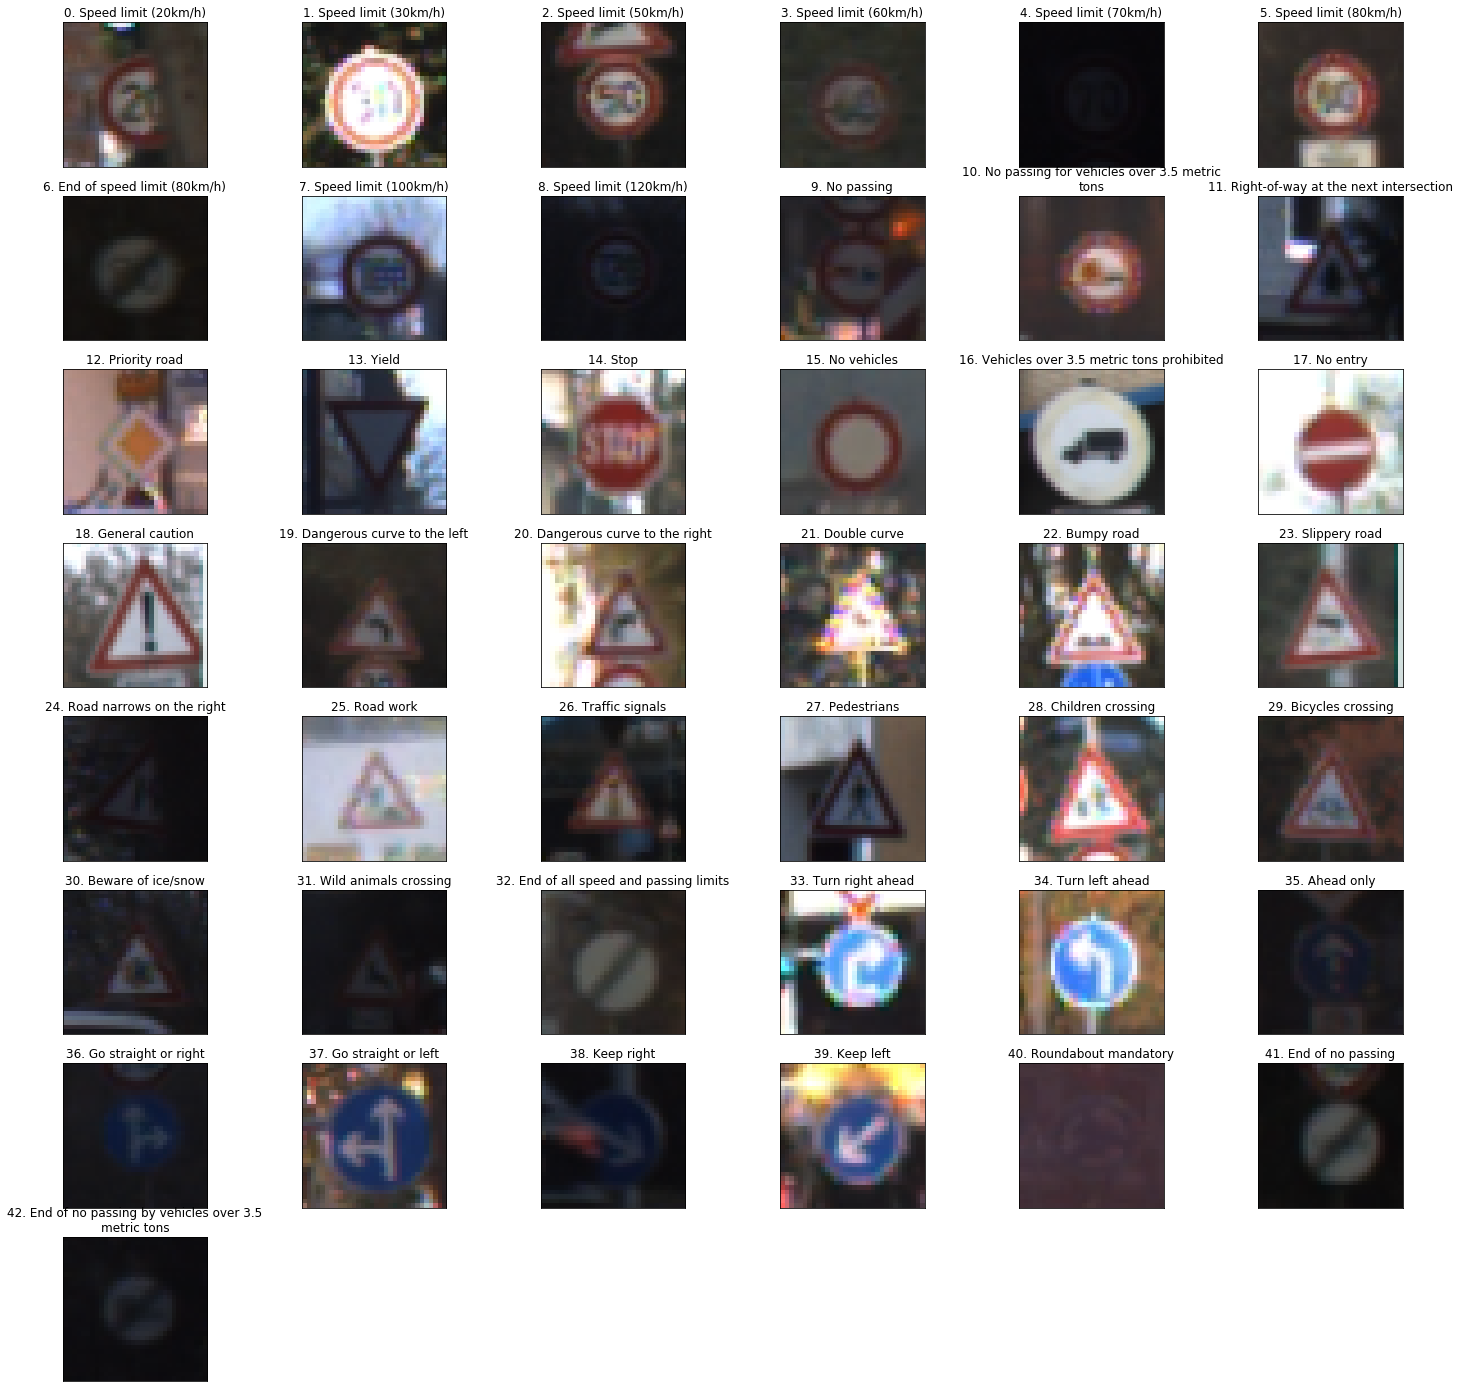

In [3]:
### Data exploration visualization code goes here.
import random
import matplotlib.pyplot as plt
from textwrap import wrap

# Visualizations will be shown in the notebook.
%matplotlib inline

def GetSignNameByClassId(sign_class_id):
    # find index of element in sign descriptions table containg info about required traffic sign
    sign_info_index = np.where(np.any(signs_description==sign_class_id, axis=1))[0][0]
    return signs_description[sign_info_index][1]

def DisplaySignClassSamplesFromDataSet(img_set, label_set) :

    max_columns=6
    rows = (len(np.unique(label_set)) / max_columns) + 1
    plt.figure(figsize=(25, 25))
    sorted_unique_classes = np.sort(np.unique(label_set))
    for i in range(len(sorted_unique_classes)):
        class_id = sorted_unique_classes[i]
        # find index of first occurance of class_id in label set
        sample_sign_index = np.where(label_set==class_id)[0][0]
        if(sample_sign_index == None):
            continue
        # get correspondent image from feature set    
        sample_sign_image = img_set[sample_sign_index].squeeze()
        # Each subplot is an example of traffic sign class with its name    
        plt.subplot(rows, max_columns, i + 1)
        # display class ID and name of traffic sign
        plt.title("{0}. {1}".format(class_id, '\n'.join(wrap(GetSignNameByClassId(class_id),40))))
        fig =plt.imshow(sample_sign_image)
        # hide image size scale axes
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
DisplaySignClassSamplesFromDataSet(X_valid, y_valid)        
        

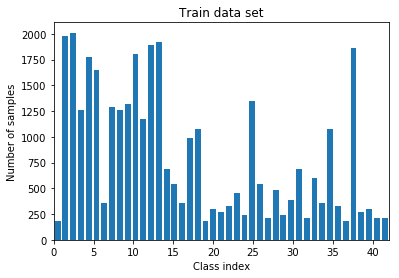

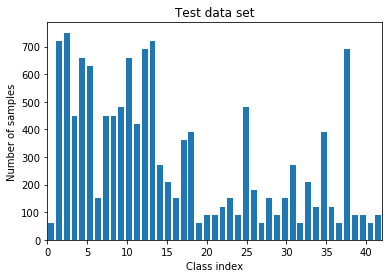

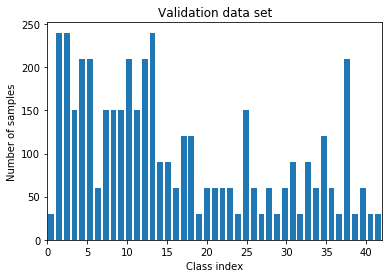

In [4]:
def DisplaySignFrequencyHistogram(title, dataset):       
   # histogram of traffic sign frequency in given dataset
    plt.hist(dataset, bins=n_classes, rwidth=0.75)
    plt.xlim(xmin=0, xmax=n_classes-1)
    plt.title(title)
    plt.xlabel("Class index")
    plt.ylabel("Number of samples")
    plt.show()     

DisplaySignFrequencyHistogram("Train data set", y_train)
DisplaySignFrequencyHistogram("Test data set", y_test)
DisplaySignFrequencyHistogram("Validation data set", y_valid)

----

## Step 2: Design and Test a Model Architecture

In this step I design and implement a deep learning model that learns to recognize traffic signs. Later on implemented odel will be trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation is used a the refernce for model implementation. To meet specifications, the validation set accuracy has to be at least 0.93.

### Pre-process the Data Set

Following preprocessing technics are applied for training, validation and test data sets:
    * Converting images from color to grayscale.
    * Normalization. The easiest way to achieve zero mean and equal variance for image data is to apply formula `(pixel_value - pixel_value_mean_over_dataset) / pixel_value_mean_over_dataset` to each of the channels of image (in our case only to one channnel, since we convert color images to grayscale first). Note! Valdiation and test datasets are normalized using the pixel_value_mean_over_dataset calculated for training dataset

Additionally following preprocessing technics are applied only to training data set
    * Rotation of images in training dataset on small random angle in a range of [5:10] degrees
    * Shuffle images in train dataset for each epoch of training


Mean for original traing set 82.6775890369964
Mean for original validation set 83.55642737563775
Mean for normalized traing set -0.009196572937071323
Mean for normalized validation set 0.0009167364332824945
Mean for normalized test set -0.01693451777100563


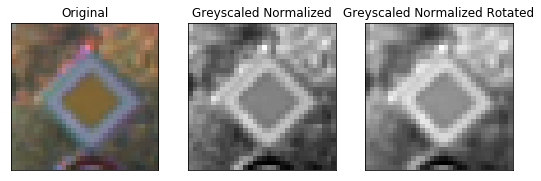

In [5]:
import cv2
#Convert to Grayscale
def ToGrayscale(dataset):
    """Applies the Grayscale transform to images in given dataset
    It returns a same size dataset of converted images"""
    
    greyscaled = []
    for image in dataset:
        greyscaled.append(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    return np.reshape(greyscaled,(-1,32,32,1))

def GetMeanPixelValueOverTrainingDataSet():
    """
    Return mean pixel value for training data set
    """
    return np.mean(X_train)

def Normalize(image, training_dataset_mean_pixel_value):
    """
    normalize the images in give dataset using a mean pixel value of training dataset as normalization factor
    """
    # convertion to float32 to support negative values
    return (image.astype(np.float32) - training_dataset_mean_pixel_value)/training_dataset_mean_pixel_value 

def RotateImagesRandomly(dataset):
    """
    Rotates images in given dataset to random angle in a range (5, 10] degrees 
    """
    rotated = []
    for image in dataset:
        img_size_x,img_size_y  = image.shape[:2]
        rotation_angle = 10.0 * np.random.rand()-5
        rotation_matrix = cv2.getRotationMatrix2D((img_size_x/2, img_size_y/2), rotation_angle, 1.0)
        rotated.append(cv2.warpAffine(image, rotation_matrix, (img_size_x, img_size_y)))
    return np.reshape(rotated,(-1,32,32,1))

def DisplayImageBeforeAndAfterPreprocessing(original, greyscaled_normalized, greyscaled_normalized_rotated):
    plt.figure(figsize=(9, 5))
    plt.subplot(1, 3, 1)
    fig = plt.imshow(original)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title("Original")
    plt.subplot(1, 3, 2)
    fig = plt.imshow(greyscaled_normalized.squeeze(),cmap='gray')
    plt.title("Greyscaled Normalized")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.subplot(1, 3, 3)
    fig = plt.imshow(greyscaled_normalized_rotated.squeeze(),cmap='gray')
    plt.title("Greyscaled Normalized Rotated")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


# normalize the training dataset to [-1,1] value range with a mean closest to zero
mnormalization_factor = GetMeanPixelValueOverTrainingDataSet()
X_train_greyscaled_normalized = Normalize(ToGrayscale(X_train), mnormalization_factor)
X_train_greyscaled_normalized_rotated = RotateImagesRandomly(X_train_greyscaled_normalized)

# normalize validation and test dataset using a normalization factor calculated for training datset
X_valid_greyscaled_normalized = Normalize(ToGrayscale(X_valid), mnormalization_factor)
X_test_greyscaled_normalized = Normalize(ToGrayscale(X_test), mnormalization_factor)

# display random image from training dataset before and after preprocessing
index = random.randint(0, len(X_train))
DisplayImageBeforeAndAfterPreprocessing(X_train[index], X_train_greyscaled_normalized[index], X_train_greyscaled_normalized_rotated[index])

print("Mean for original traing set {0}".format(np.mean(X_train)))
print("Mean for original validation set {0}".format(np.mean(X_valid)))
print("Mean for normalized traing set {0}".format(np.mean(X_train_greyscaled_normalized)))
print("Mean for normalized validation set {0}".format(np.mean(X_valid_greyscaled_normalized)))
print("Mean for normalized test set {0}".format(np.mean(X_test_greyscaled_normalized)))



# Model Architecture

The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since Traffic Sign images arein RGB color, C is 1 in this case since we converted images from color (3 channels) to greyscale (1 channel)

Model Architecture:

Model Architecture:
Layer 1: Convolutional. The output shape should be 28x28x6. Activation: Relu   
Layer 2: Pooling: The output shape is 14x14x6   
Layer 3: Convolutional. The output shape is 10x10x16. Activation: Relu   
Layer 4: Pooling: The output shape is 5x5x16   
Layer 5: Flatten: Input shape: 5x5x16. Output shape: 400x1    
Layer 6: Fully Connected. Inputs: 400. Outputs: 120. Activation: Relu. Dropout: 25%   
Layer 7: Fully Connected. Inputs: 120. Outputs: 84.  Activation: Relu. Dropout: 25%   
Layer 8: Fully Connected. Inputs: 84. Outputs: 43   

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Layer 2: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Layer 4: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 5: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 6: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 7: Fully Connected. Input = 400. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 8: Fully Connected. Input = 84. Output = 43 classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


# Placeholder to store input batches
# (BATCH_SIZE, height, width, depth)
x = tf.placeholder(tf.float32, (None, 32, 32, 1))

# Placeholder for labels
y = tf.placeholder(tf.int32, (None))

# One-hot encoding of labels
one_hot_y = tf.one_hot(y, 43)

# Probability to keep units
keep_prob = tf.placeholder(tf.float32)

#Training pipeine

EPOCHS = 25
BATCH_SIZE = 128
rate = 0.0003

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



### Train, Validate and Test the Model

A validation set is used to assess how well the model is performing. A low accuracy on the training and validation
sets will imply underfitting. A high accuracy on the training set but low accuracy on the validation set will imply overfitting.

In [7]:
from sklearn.utils import shuffle

#form the resulting training set of features
X_train=[]
X_train.extend(X_train_greyscaled_normalized)
X_train.extend(X_train_greyscaled_normalized_rotated)

# double the size of trainig set of labels accordingly
y_train_adjusted = []
y_train_adjusted.extend(y_train)
y_train_adjusted.extend(y_train)
y_train = y_train_adjusted

X_valid=X_valid_greyscaled_normalized
X_test=X_test_greyscaled_normalized

accuracies = list()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Started Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        accuracies.append((train_accuracy,validation_accuracy))
        print()
        
    saver.save(sess, './checkpoints/trained_model.ckpt')
    print("Model saved")

Started Training...

EPOCH 1 ...
Train Accuracy = 0.717
Validation Accuracy = 0.675

EPOCH 2 ...
Train Accuracy = 0.894
Validation Accuracy = 0.859

EPOCH 3 ...
Train Accuracy = 0.935
Validation Accuracy = 0.896

EPOCH 4 ...
Train Accuracy = 0.955
Validation Accuracy = 0.921

EPOCH 5 ...
Train Accuracy = 0.969
Validation Accuracy = 0.928

EPOCH 6 ...
Train Accuracy = 0.977
Validation Accuracy = 0.934

EPOCH 7 ...
Train Accuracy = 0.980
Validation Accuracy = 0.926

EPOCH 8 ...
Train Accuracy = 0.986
Validation Accuracy = 0.941

EPOCH 9 ...
Train Accuracy = 0.987
Validation Accuracy = 0.940

EPOCH 10 ...
Train Accuracy = 0.988
Validation Accuracy = 0.942

EPOCH 11 ...
Train Accuracy = 0.991
Validation Accuracy = 0.940

EPOCH 12 ...
Train Accuracy = 0.992
Validation Accuracy = 0.949

EPOCH 13 ...
Train Accuracy = 0.994
Validation Accuracy = 0.947

EPOCH 14 ...
Train Accuracy = 0.994
Validation Accuracy = 0.948

EPOCH 15 ...
Train Accuracy = 0.996
Validation Accuracy = 0.946

EPOCH 16 ...


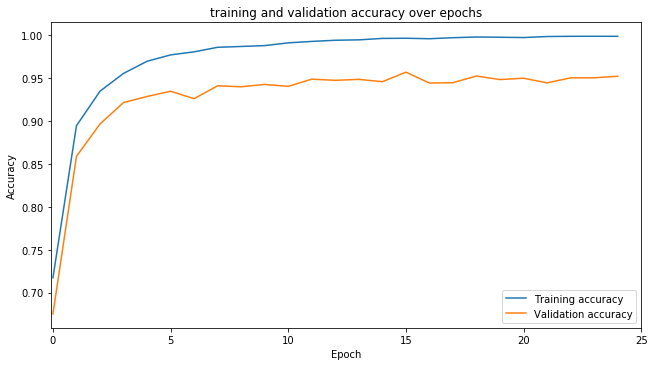

In [10]:
# display training and validation accuracy gain over training epochs
plt.figure(figsize=(9,5))
plt.title('training and validation accuracy over epochs')
plt.plot([acc[0] for acc in accuracies])
plt.plot([acc[1] for acc in accuracies])
plt.xlim([-.1,25])
plt.legend(['Training accuracy','Validation accuracy'])
plt.tight_layout()
plt.ylabel('Accuracy')
plt.xlabel('Epoch');

In [11]:
# Evaluate model accuracy on test datasets
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints/'))
    print('Classification Accuracy On Test Dataset: {:.3f}'.format(evaluate(X_test,y_test)))

Classification Accuracy On Test Dataset: 0.937


---

## Step 3: Test a Model on New Images

To get insight into how good the trained model is working, it is evaluated on 5 random pictures of German traffic signs downloaded from the web.

### Load and Output the Images

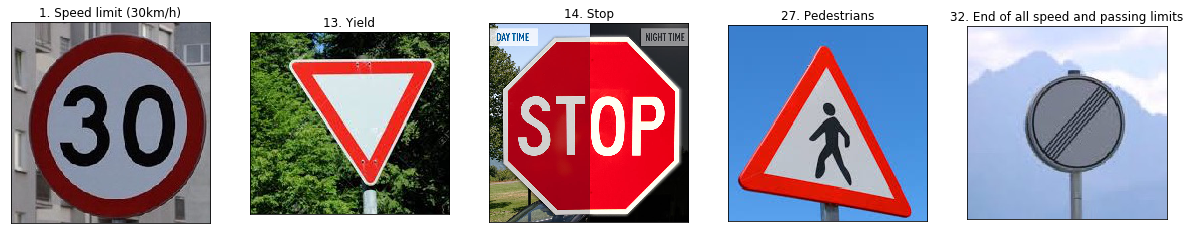

In [13]:
import glob

web_images = []
X_web = []
Y_web = []

image_files = glob.glob('model_test_signs/*.jpg')

for file in image_files:
    image =  cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    web_images.append(image)
    # resize original image and add to dataset for testing
    X_web.append(cv2.resize(image, (32, 32)))
    # get class id of traffic sign from file name (first two characters)
    class_id = int(file.split('/')[-1][:2])
    Y_web.append(class_id)

DisplaySignClassSamplesFromDataSet(web_images, Y_web)

### Predict the Sign Type for Each Image

In [14]:
X_web = Normalize(ToGrayscale(X_web), mnormalization_factor)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints/'))
    test_accuracy = evaluate(X_web, Y_web)
    predicted_labels = sess.run(tf.argmax(logits, 1), feed_dict={x: X_web, keep_prob: 1.0})

### Analyze Performance

Prediction Accuracy = 0.800


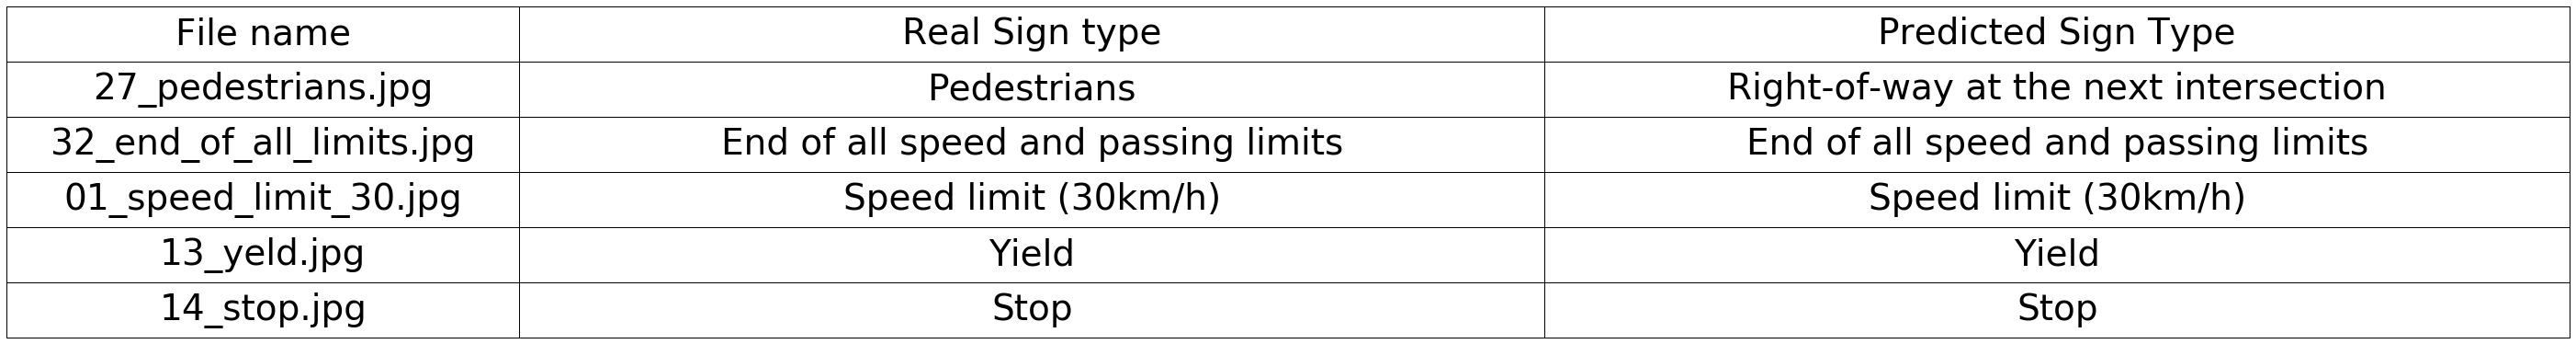

In [16]:
print("Prediction Accuracy = {:.3f}".format(test_accuracy))
fig, ax = plt.subplots(figsize=(10,2))
ax.set_axis_off()
collabels=("File name", "Real Sign type", "Predicted Sign Type")
table_cells = []
for i in range(len(Y_web)):
    table_cells.append([image_files[i].split('/')[-1], GetSignNameByClassId(Y_web[i]), GetSignNameByClassId(predicted_labels[i])])
tbl = ax.table(cellText=table_cells,colLabels=collabels,loc='center', colWidths=[.2,.4,.4], cellLoc='center')  
tbl.set_fontsize(50)
tbl.scale(5, 5)

plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the test images downloaded from WEB, print out the model's top 5 softmax probabilities to show the **certainty** of the model's predictions

In [17]:
softmax = tf.nn.softmax(logits)
predictor = tf.nn.top_k(softmax, k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints/'))
    prediction = sess.run(predictor, feed_dict={x: X_web, keep_prob: 1.})
    for i in range(len(X_web)):
        print("Top 5 predictions for image in file '{0}':".format(image_files[i].split('/')[-1]))
        for j in range(len(prediction[1][i])):
            print("\t{:s}: {:.2f}%".format(signs_description[prediction[1][i][j]][1], prediction[0][i][j]*100))
        print()    

Top 5 predictions for image in file '27_pedestrians.jpg':
	Right-of-way at the next intersection: 87.26%
	Pedestrians: 12.74%
	General caution: 0.00%
	Double curve: 0.00%
	Beware of ice/snow: 0.00%

Top 5 predictions for image in file '32_end_of_all_limits.jpg':
	End of all speed and passing limits: 66.35%
	Speed limit (60km/h): 23.45%
	Priority road: 8.65%
	Ahead only: 0.74%
	Children crossing: 0.33%

Top 5 predictions for image in file '01_speed_limit_30.jpg':
	Speed limit (30km/h): 100.00%
	Speed limit (50km/h): 0.00%
	Speed limit (60km/h): 0.00%
	Keep right: 0.00%
	Roundabout mandatory: 0.00%

Top 5 predictions for image in file '13_yeld.jpg':
	Yield: 100.00%
	No passing for vehicles over 3.5 metric tons: 0.00%
	Ahead only: 0.00%
	No vehicles: 0.00%
	Speed limit (80km/h): 0.00%

Top 5 predictions for image in file '14_stop.jpg':
	Stop: 100.00%
	Go straight or right: 0.00%
	Speed limit (60km/h): 0.00%
	Keep right: 0.00%
	Yield: 0.00%

